<a href="https://colab.research.google.com/github/AXBOUF/python_visulization/blob/main/NYC_TAXI_TRIP_DURATION_MUNAL_BARAILI_90006725.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICT TRIP DURATION
### Here is the report for the insights and discussion of the project
##### https://github.com/AXBOUF/python_visulization/blob/main/MUNAL_BARAILI_900006725_NYC_TAXI.pdf

# SPARK SESSION AND LOADING DATA

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('nyc_trip_predict').getOrCreate()
data_trip=spark.read.csv('nyc_taxi_trip_duration.csv', header=True, inferSchema=True)
data_trip.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



In [ ]:
spark

spark did good job recognizing the datatype of different features even tho lets peek the head of data

In [ ]:
# lets try stick with spark syntax and use less of
data_trip.show(5)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id1080784|        2|2016-02-29 16:40:21|2016-02-29 16:47:01|              1|-73.95391845703125| 40.77887344360352|-73.96387481689453| 40.77116394042969|                 N|          400|
|id0889885|        1|2016-03-11 23:35:37|2016-03-11 23:53:57|              2|-73.98831176757811| 40.73174285888672| -73.9947509765625| 40.69493103027344|                 N|         1100|
|id0857912|        2|2016-02-21 17:59:33|2016-02-21 18:26:48|    

General walkthrough

id - unique trip id, vendor_id - 1,2 , pickup_datetime, dropoff_datetime (yyyy-mm-dd hh:mm:ss ), passenger_count number of passenger in a trip, pickup_longitude and latitude pin points the pickup location similarly dropoff gives the drop off location.

store_and_fwd_flag - no idea for now, trip_duration is our dependent variable which we will attempt to predict by using rest of independent variables.




# DATA EXPLORATION - SETTING UP STAGE BEFORE DATA CLEANING

In [ ]:
data_trip.describe().show()

+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|    pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|
+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+
|  count|   729322|            729322|            729322|             729322|             729322|             729322|             729322|            729322|            729322|
|   mean|     NULL|1.5354027439183242|1.6620546205928246| -73.97351307454848|  40.75091887972495| -73.97342219209891| 40.751775436975464|              NULL| 952.2291333594764|
| stddev|     NULL|0.4987454128000744|1.3124456158621784|0.06975384025050611|0.03359412072122873|0.06958815677984773|0.0

## count is consistent among all the variables that a good sight (729322)

In [ ]:
from pyspark.sql import functions as F

data_trip.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data_trip.columns]).show()


+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
| id|vendor_id|pickup_datetime|dropoff_datetime|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|store_and_fwd_flag|trip_duration|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+
|  0|        0|              0|               0|              0|               0|              0|                0|               0|                 0|            0|
+---+---------+---------------+----------------+---------------+----------------+---------------+-----------------+----------------+------------------+-------------+



#### thats a good sign that dataset holds no null values thank you !!

Interesting findings on passenger_count and trip_duration lets see that up close

In [ ]:
# lets see only one feature description
data_trip.select('passenger_count','trip_duration').describe().show()

+-------+------------------+------------------+
|summary|   passenger_count|     trip_duration|
+-------+------------------+------------------+
|  count|            729322|            729322|
|   mean|1.6620546205928246| 952.2291333594764|
| stddev|1.3124456158621784|3864.6261972812454|
|    min|                 0|                 1|
|    max|                 9|           1939736|
+-------+------------------+------------------+



Call me insane but a trip 1939736 sec ~ 538.8155556 hours is an absolute outliers similarly trip lasting 1 sec too.

On other hand passenger_count 0, 9 could be possible considering a van trip or supposedly a larger SUV but we will see how many are there and conclude if it is an outlier or not. Potentially it maybe an outlier.  

lets see the count of vendor_id to see if the dataset consists of balanced data from both vendor and we will also later conclude of vendor id plays any significane when it comes to data trip duration or not

# FEATURE EXPLORATION AND THERE PLOTS

In [ ]:
# lets see the count of vendor_id to see if the dataset consists of balanced data from both vendor
vendor_spread = data_trip.groupBy('vendor_id').count()

In [ ]:
pdf = vendor_spread.toPandas()

In [ ]:
# i will try to use same color palette to refer to vendor id 1 and vendor id 2
my_palette = ["#77B7A8", "#E09E7E"]

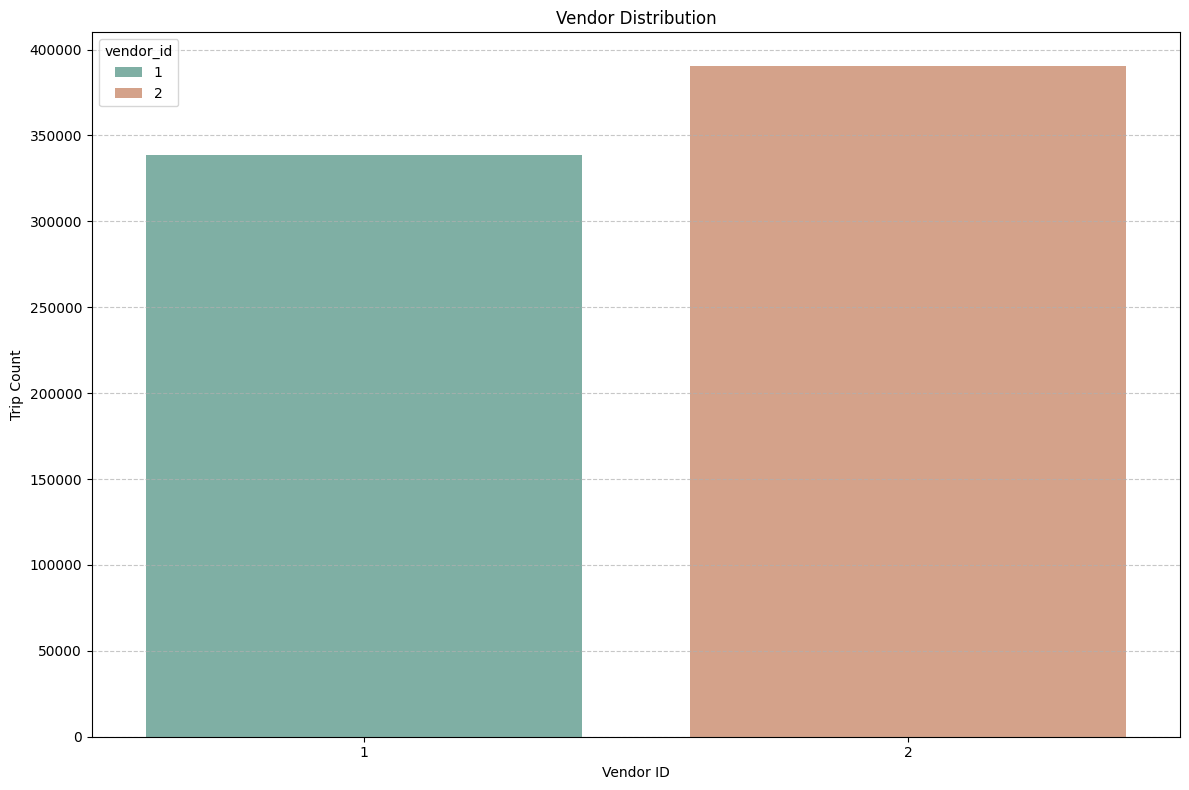

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(12,8))
ax = sns.barplot(data=pdf,x="vendor_id",y="count",hue="vendor_id",palette=my_palette)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.title("Vendor Distribution")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Count")
plt.tight_layout()
plt.show()

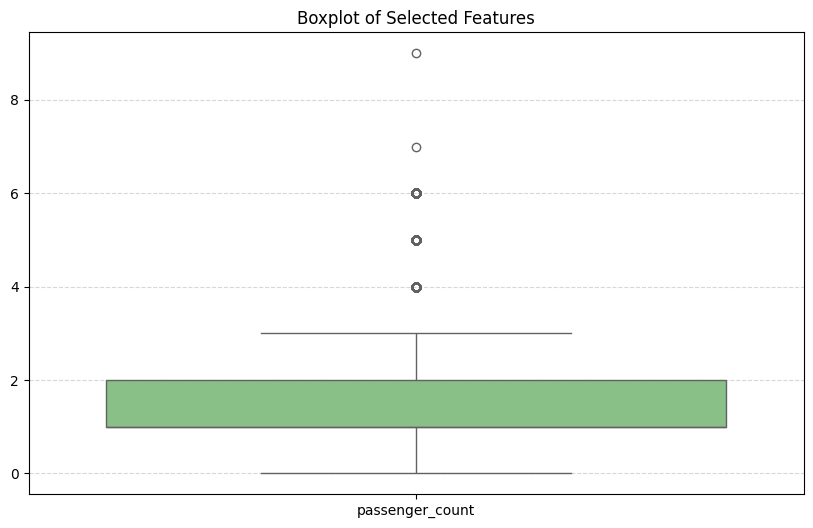

In [ ]:
# lets see now the boxplot of passenger_count to address if there are any outlier
# We can see most data are spread between 0-3 passenger count range
features = ["passenger_count"]
pdf = data_trip.select(*features).toPandas()

plt.figure(figsize=(10, 6))
sns.boxplot(data=pdf, palette='Accent') # other color paletter recommendation ~ Set2, Set1, tab10, Accent, crest, rocket.
plt.title("Boxplot of Selected Features")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

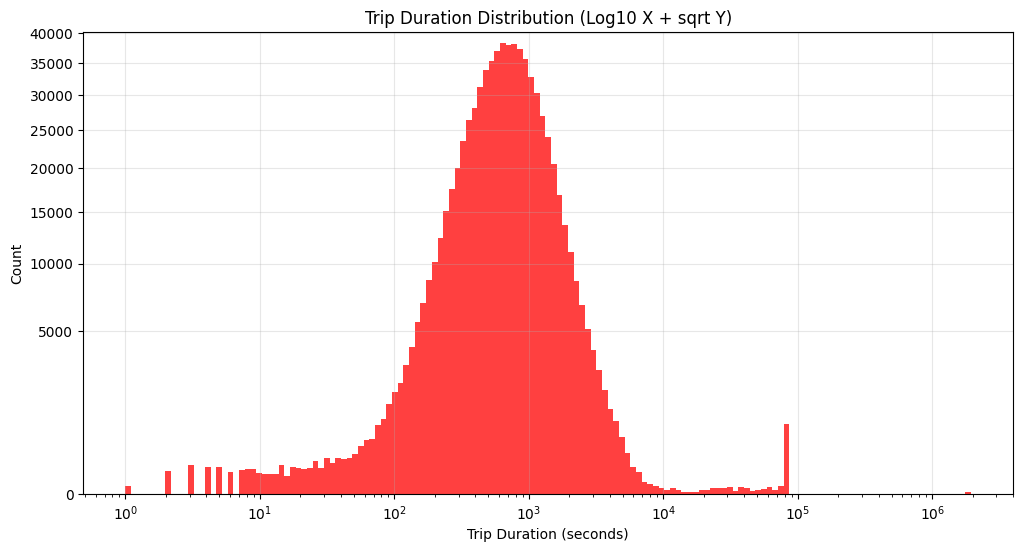

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale
pdf = data_trip.select("trip_duration").toPandas()

plt.figure(figsize=(12, 6))

# histogram with log-spaced bins (CRITICAL PART)
bins = np.logspace(
    np.log10(pdf["trip_duration"].min()),
    np.log10(pdf["trip_duration"].max()),
    150
)
# why do this - trip has huge mass of short trips and a long tail of very big values if we use normal bins, 95% of the histogram collapses.
# thats why we are stretching the lower part and compressing the long tail.
sns.histplot(pdf["trip_duration"], bins=bins, color="red")

# log-scale x axis
plt.xscale("log")

# sqrt y scale (ggplot equivalent)
plt.yscale('function', functions=(np.sqrt, lambda y: y**2))

plt.title("Trip Duration Distribution (Log10 X + sqrt Y)")
plt.xlabel("Trip Duration (seconds)")
plt.ylabel("Count")
plt.grid(alpha=0.3)

plt.show()


Most trips look kind of log-normal with a big peak just under 1000 seconds (around 15–20 minutes). There are a bunch of weird super-short trips under 10 seconds, which are probably data errors. There’s also a sharp spike right before 1e5 seconds and a few trips way beyond that, meaning there are some extreme outliers where the trip duration is recorded in hours or even days.

We will further filter the trip duration based on more or less than certain hours or min and make a decision.

In [ ]:
pdf['trip_duration'].describe()

count    7.293220e+05
mean     9.522291e+02
std      3.864626e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.630000e+02
75%      1.075000e+03
max      1.939736e+06
Name: trip_duration, dtype: float64

### lets peek the duration of dataset we have for the trip since when its recored

In [ ]:
import pyspark.sql.functions as F

data_trip.agg(
    F.min("pickup_datetime").alias("start"),
    F.max("pickup_datetime").alias("end")
).show()

+-------------------+-------------------+
|              start|                end|
+-------------------+-------------------+
|2016-01-01 00:01:14|2016-06-30 23:59:37|
+-------------------+-------------------+



1ST OF JANUARY 2016 - 30TH OF JUNE 2016.

This gives us an idea of start and end of recorded trip data in the whole dataset

In [ ]:
import pyspark.sql.functions as F

data_trip = data_trip.withColumn(
    "pickup_ym",
    F.date_format("pickup_datetime", "yyyy-MM")
)


In [ ]:
monthly = (
    data_trip.groupBy("pickup_ym")
             .count()
             .orderBy("pickup_ym")
)


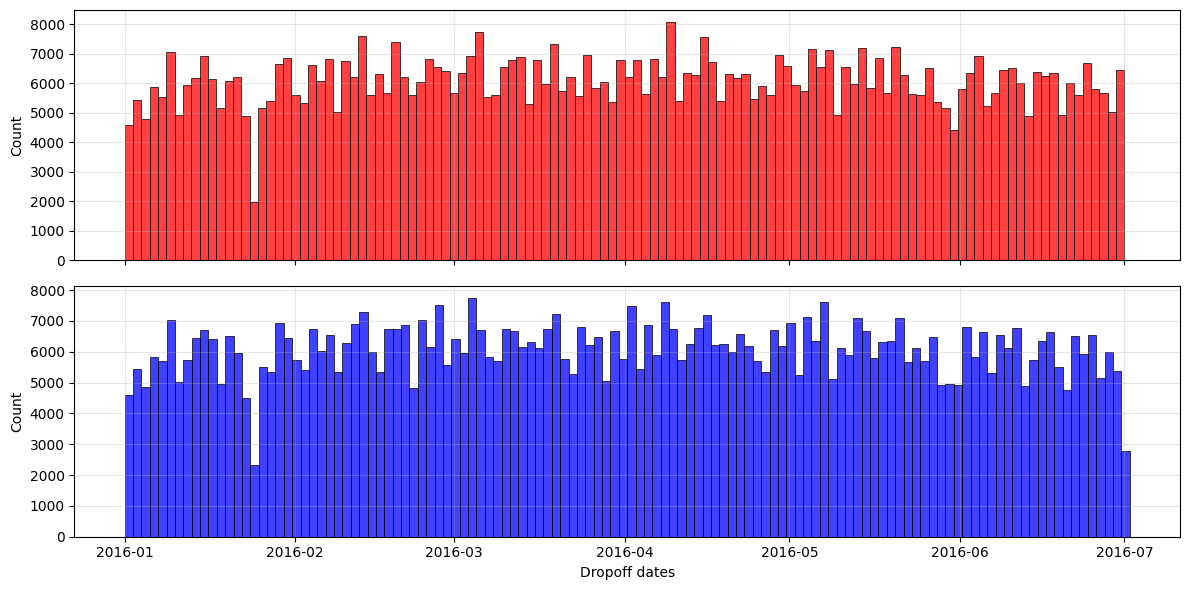

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Convert columns to pandas first
pdf = data_trip.select("pickup_datetime", "dropoff_datetime").toPandas()

# Pickup histogram
sns.histplot(pdf["pickup_datetime"], bins=120, color="red", ax=axes[0])
axes[0].set_xlabel("Pickup dates")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# Dropoff histogram
sns.histplot(pdf["dropoff_datetime"], bins=120, color="blue", ax=axes[1])
axes[1].set_xlabel("Dropoff dates")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



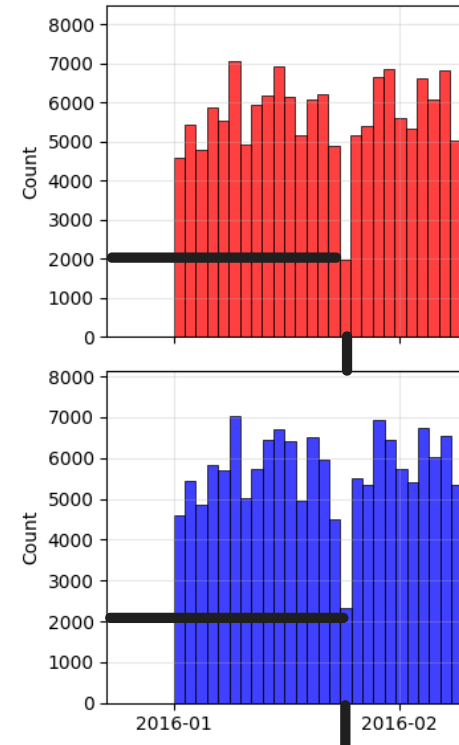

Closer look tell the lowest recorded near end of January with count approx 2000, which could be due to many factor weather, event, shutdown....

In [ ]:
import pyspark.sql.functions as F

data_trip = (
    data_trip
    # pickup
    .withColumn("pickup_date",     F.to_date("pickup_datetime"))
    .withColumn("pickup_year",     F.year("pickup_datetime"))
    .withColumn("pickup_month",    F.month("pickup_datetime"))
    .withColumn("pickup_day",      F.dayofmonth("pickup_datetime"))
    .withColumn("pickup_hour",     F.hour("pickup_datetime"))
    .withColumn("pickup_minute",   F.minute("pickup_datetime"))
    .withColumn("pickup_weekday",  F.dayofweek("pickup_datetime"))  # 1 = Sunday

    # dropoff
    .withColumn("dropoff_date",     F.to_date("dropoff_datetime"))
    .withColumn("dropoff_year",     F.year("dropoff_datetime"))
    .withColumn("dropoff_month",    F.month("dropoff_datetime"))
    .withColumn("dropoff_day",      F.dayofmonth("dropoff_datetime"))
    .withColumn("dropoff_hour",     F.hour("dropoff_datetime"))
    .withColumn("dropoff_minute",   F.minute("dropoff_datetime"))
    .withColumn("dropoff_weekday",  F.dayofweek("dropoff_datetime"))
)


breaking down both pickup and dropoff datetimes into granular features (year, month, day, hour, minute, weekday) so I don’t have to repeatedly strip time components later. This makes grouping, plotting, and analysing time-based patterns much easier and faster throughout the notebook.

In [ ]:
weekday_vendor = (
    data_trip.groupBy("pickup_weekday", "vendor_id")
             .count()
             .orderBy("pickup_weekday", "vendor_id")
)


In [ ]:
pdf_wv = weekday_vendor.toPandas()


In [ ]:
weekday_map = {
    1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed",
    5: "Thu", 6: "Fri", 7: "Sat"
}

pdf_wv["weekday"] = pdf_wv["pickup_weekday"].map(weekday_map)


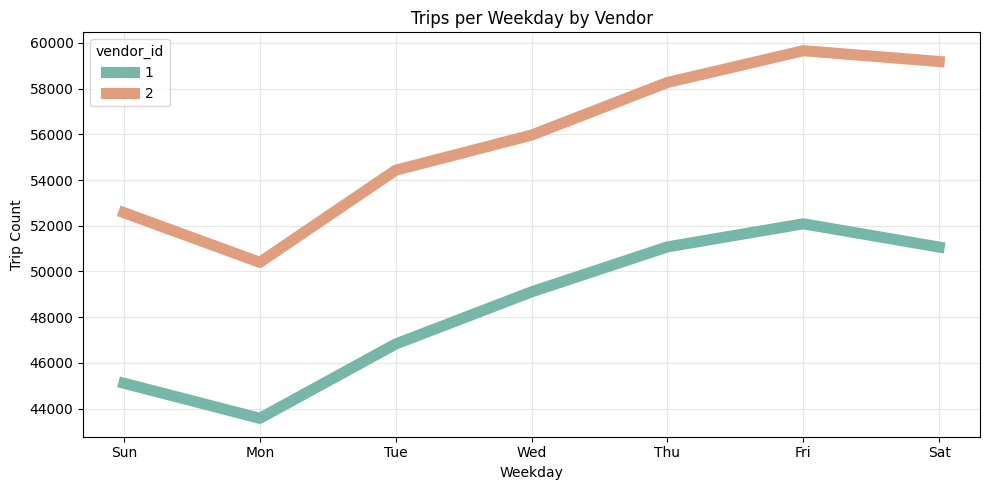

In [ ]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=pdf_wv,
    x="weekday",
    y="count",
    hue="vendor_id",
    markers=True,
    palette=my_palette,
    linewidth= 8
)

plt.title("Trips per Weekday by Vendor")
plt.xlabel("Weekday")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Interesting finding , both vendors follow the same weekday pattern: slowest on sunday and monday, then trips gradually climb.

Vendor 2 has consistenly more rides than vendor 1 also the shape is somehow identical for both.

### Lets see spread in hours of the day

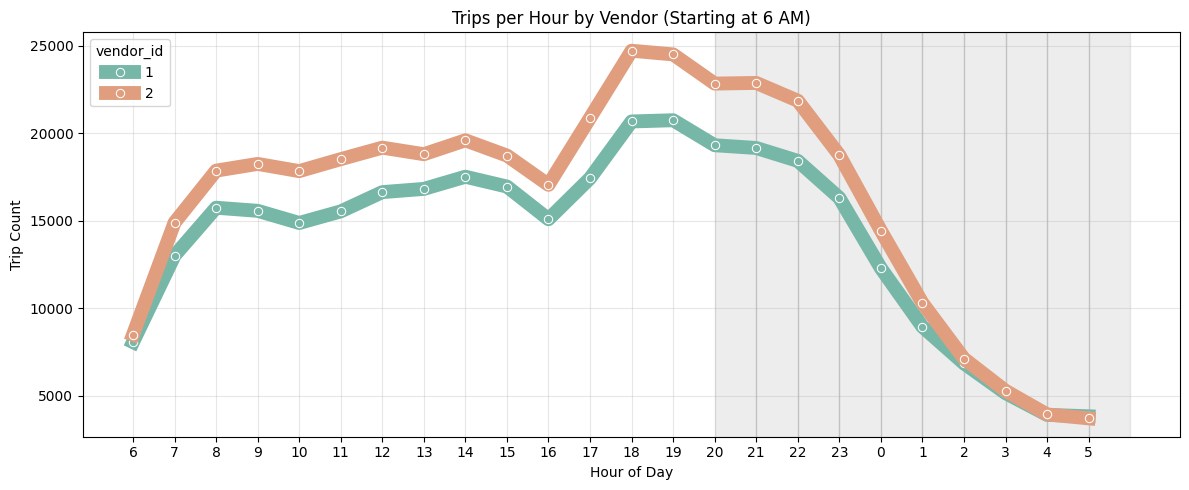

In [ ]:
hour_vendor = (
    data_trip.groupBy("pickup_hour", "vendor_id")
             .count()
             .orderBy("pickup_hour", "vendor_id")
)

pdf_hv = hour_vendor.toPandas()

# rotate hours so the plot starts at 6 AM
pdf_hv["rot_hour"] = (pdf_hv["pickup_hour"] - 6) % 24

# sort by the rotated hour
pdf_hv = pdf_hv.sort_values("rot_hour")

plt.figure(figsize=(12,5))

sns.lineplot(
    data=pdf_hv,
    x="rot_hour",
    y="count",
    hue="vendor_id",
    marker="o",
    palette=my_palette,
    linewidth= 10
)

plt.title("Trips per Hour by Vendor (Starting at 6 AM)")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)

# night shading for real hours (20–23 and 0–5)
night_hours = list(range(20, 24)) + list(range(0, 6))

for h in night_hours:
    plt.axvspan((h-6)%24, (h-6)%24 + 1, color="black", alpha=0.07)

# x-axis labels should show REAL hours
plt.xticks(
    ticks=range(24),
    labels=[(h + 6) % 24 for h in range(24)]
)

plt.tight_layout()
plt.show()


If we plot the line starting from 6am we can see a clear pattern of trips starting same at 6 am between both vendor then the vendor 2 trip count goes up following the general count of both vendor peaking during late evening then line goes steep down from midnight.


Overview people are taking taxi generally during day with peak demand during late evening and steep low demand after midnight with lowest count early morning 5am

/tmp/ipython-input-3647264193.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pass_count, x="passenger_count", y="count", palette="Pastel1")


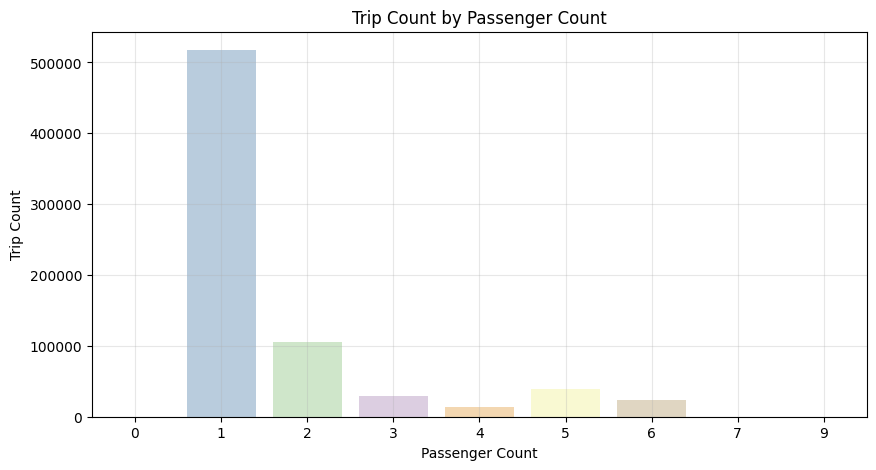

In [ ]:
# lets visualize passenger_count
passenger_count = (
    data_trip.groupBy("passenger_count")
             .count()
             .orderBy("passenger_count")
)

pass_count = passenger_count.toPandas()

plt.figure(figsize=(10,5))
sns.barplot(data=pass_count, x="passenger_count", y="count", palette="Pastel1")
plt.title("Trip Count by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Count")
plt.grid(alpha=0.3)
plt.show()

WE CAN SEE IT SHOWS 0 7 9 AS PASSESNGER COUNT WHICH TELLS THERE ARE VERY LESS TRIP WITH THOSE PASSENGER COUNT

### Most of the passenger count is 1 which tells most taxi trips are for single person

In [ ]:
month_labels = {
    1:"Jan",2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",
    7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"
}

weekday_labels = {
    1:"Sun",2:"Mon",3:"Tue",4:"Wed",5:"Thu",6:"Fri",7:"Sat"
}
hour_month = (
    data_trip.groupBy("pickup_hour", "pickup_month")
             .count()
             .orderBy("pickup_hour", "pickup_month")
)

pdf_hm = hour_month.toPandas()
pdf_hm["Month"] = pdf_hm["pickup_month"].map(month_labels)


In [ ]:
hour_weekday = (
    data_trip.groupBy("pickup_hour", "pickup_weekday")
             .count()
             .orderBy("pickup_hour", "pickup_weekday")
)

pdf_hw = hour_weekday.toPandas()
pdf_hw["Wday"] = pdf_hw["pickup_weekday"].map(weekday_labels)


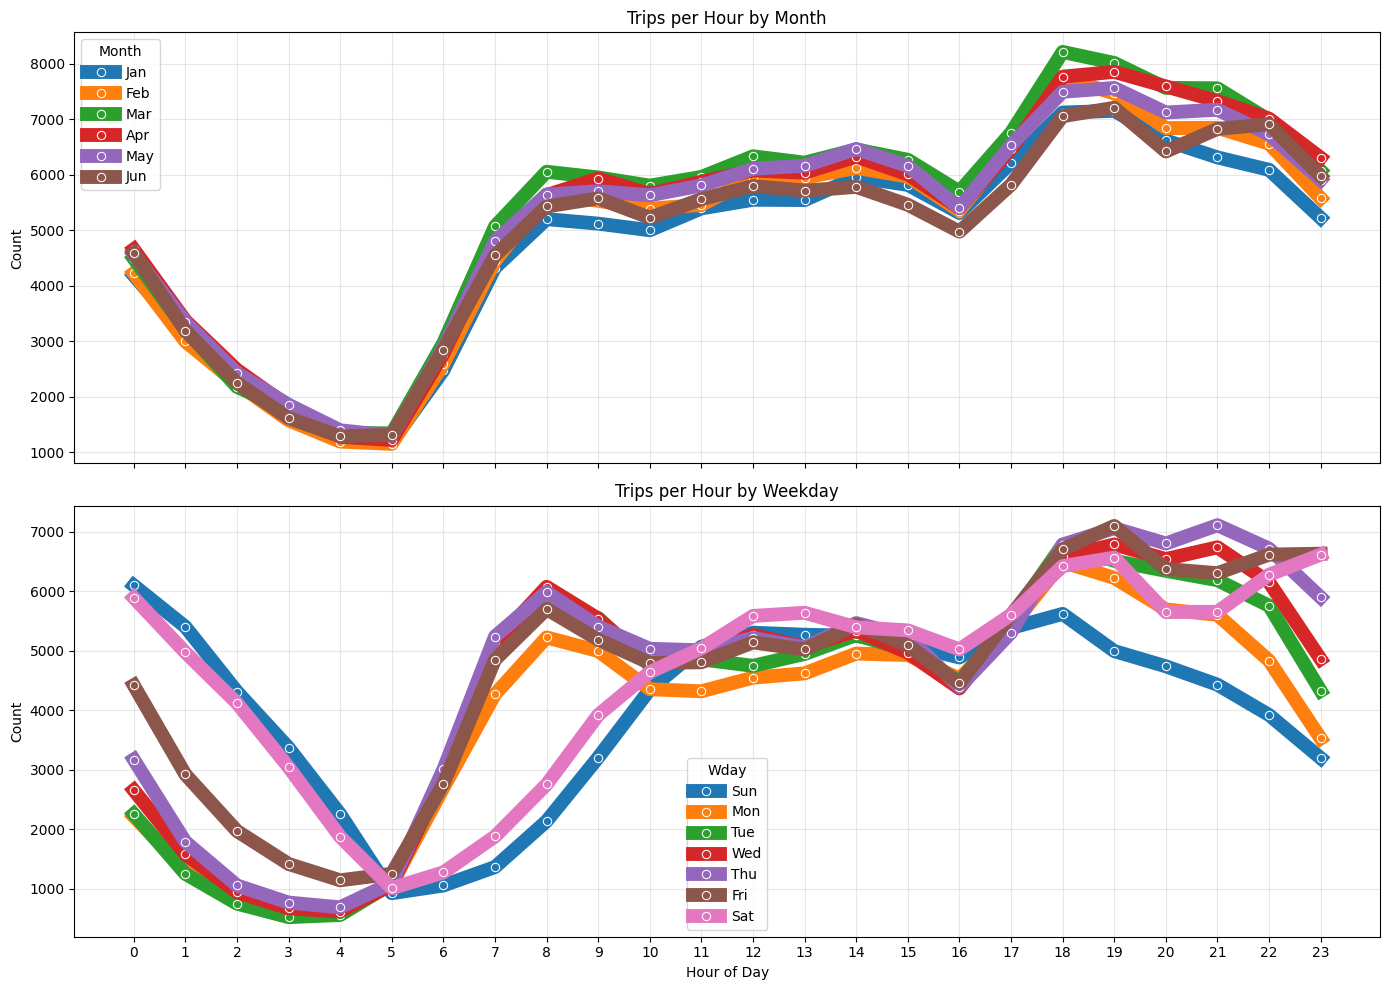

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# p1 — hour × month
sns.lineplot(
    data=pdf_hm,
    x="pickup_hour",
    y="count",
    hue="Month",
    ax=axes[0],
    marker="o",
    linewidth=10 # more width helps visualize the dominance line
)
axes[0].set_title("Trips per Hour by Month")
axes[0].set_ylabel("Count")
axes[0].grid(alpha=0.3)

# p2 — hour × weekday
sns.lineplot(
    data=pdf_hw,
    x="pickup_hour",
    y="count",
    hue="Wday",
    ax=axes[1],
    marker="o",
    linewidth=10
)
axes[1].set_title("Trips per Hour by Weekday")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Count")
axes[1].grid(alpha=0.3)

plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


January and June seem to have fewer trips overall, while March and April stand out as the busier months. Both vendors follow this same general pattern, so it looks like a dataset-wide trend rather than something vendor-specific.

The weekend behaviour is noticeably different from the weekday flow. Late-night and early-morning hours (especially Friday and Saturday) see more activity, which lines up with typical NYC nightlife. But from around 5 AM to 10 AM, trip counts dip on weekends compared to weekdays because there’s no morning commute. There’s also a clear drop-off on Sunday evening as the weekend wraps up.

## “Added a thicker line width so the dominant trends stand out more clearly and are easier to compare across months and weekdays.”

## latitude longitude

In [ ]:
MIN_LON, MAX_LON = -74.05, -73.70
MIN_LAT, MAX_LAT = 40.60, 40.90


In [ ]:
filtered = (
    data_trip
    .filter((F.col("pickup_longitude") > MIN_LON) & (F.col("pickup_longitude") < MAX_LON))
    .filter((F.col("dropoff_longitude") > MIN_LON) & (F.col("dropoff_longitude") < MAX_LON))
    .filter((F.col("pickup_latitude") > MIN_LAT) & (F.col("pickup_latitude") < MAX_LAT))
    .filter((F.col("dropoff_latitude") > MIN_LAT) & (F.col("dropoff_latitude") < MAX_LAT))
)


In [ ]:
pdf_f = filtered.select(
    "pickup_longitude", "dropoff_longitude",
    "pickup_latitude", "dropoff_latitude"
).toPandas()


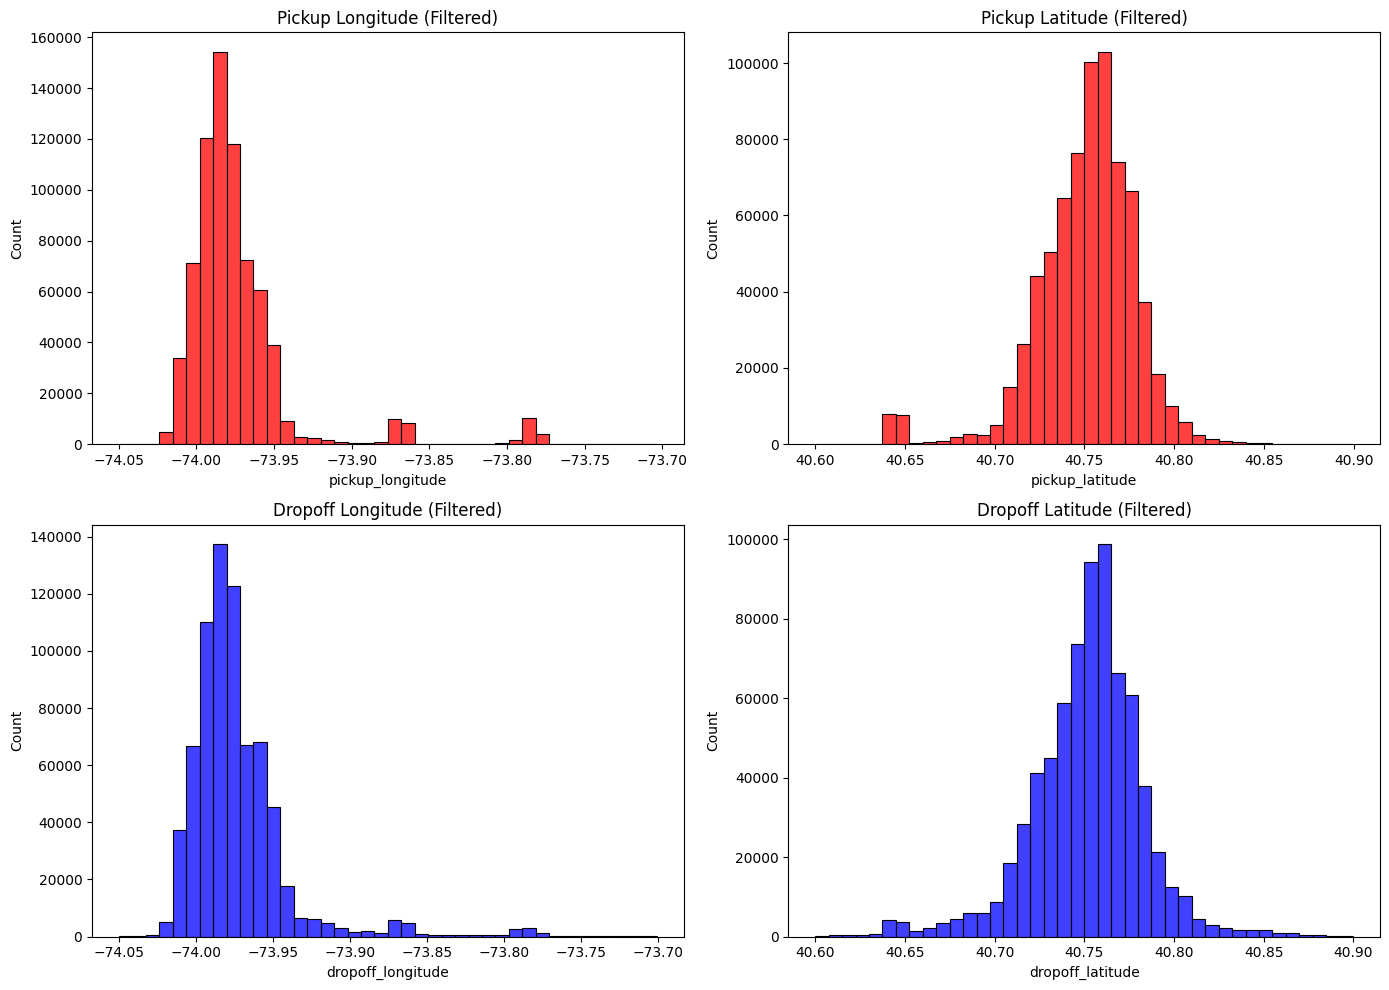

In [ ]:
plt.figure(figsize=(14, 10))

# pickup longitude
plt.subplot(2, 2, 1) # the last number refers to the position in the plot
sns.histplot(pdf_f["pickup_longitude"], bins=40, color="red")
plt.title("Pickup Longitude (Filtered)")

# pickup latitude
plt.subplot(2, 2, 2)
sns.histplot(pdf_f["pickup_latitude"], bins=40, color="red")
plt.title("Pickup Latitude (Filtered)")

# dropoff longitude
plt.subplot(2, 2, 3)
sns.histplot(pdf_f["dropoff_longitude"], bins=40, color="blue")
plt.title("Dropoff Longitude (Filtered)")



# dropoff latitude
plt.subplot(2, 2, 4)
sns.histplot(pdf_f["dropoff_latitude"], bins=40, color="blue")
plt.title("Dropoff Latitude (Filtered)")

plt.tight_layout()
plt.show()


We constrained the latitude and longitude ranges because a handful of trips had coordinates far outside NYC, which would distort the histograms. After filtering to a reasonable NYC bounding box, the location distributions line up with what we saw on the map earlier — most activity is concentrated around Manhattan, with the expected spread into nearby boroughs.

### We’re not cleaning the data yet — this filter is just for exploration so the plots make sense. The actual dataset cleaning will happen later in the proper preprocessing phase.

# VISUAIZING DIFFERENT FEATURES AND THERE REALTION WITH TRIP_DURATION

In [ ]:
import pandas as pd


In [ ]:
weekday_vendor = (
    data_trip.groupBy("pickup_weekday", "vendor_id")
             .agg(F.expr("percentile_approx(trip_duration, 0.5)").alias("median_trip"))
)

pdf_wv = weekday_vendor.toPandas()

# convert seconds → minutes
pdf_wv["median_minutes"] = pdf_wv["median_trip"] / 60

# weekday labels (R uses Monday as start)
weekday_labels = {1:"Sun", 2:"Mon", 3:"Tue", 4:"Wed", 5:"Thu", 6:"Fri", 7:"Sat"}
pdf_wv["weekday"] = pdf_wv["pickup_weekday"].map(weekday_labels)

# keep weekday order
order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
pdf_wv["weekday"] = pd.Categorical(pdf_wv["weekday"], categories=order, ordered=True)


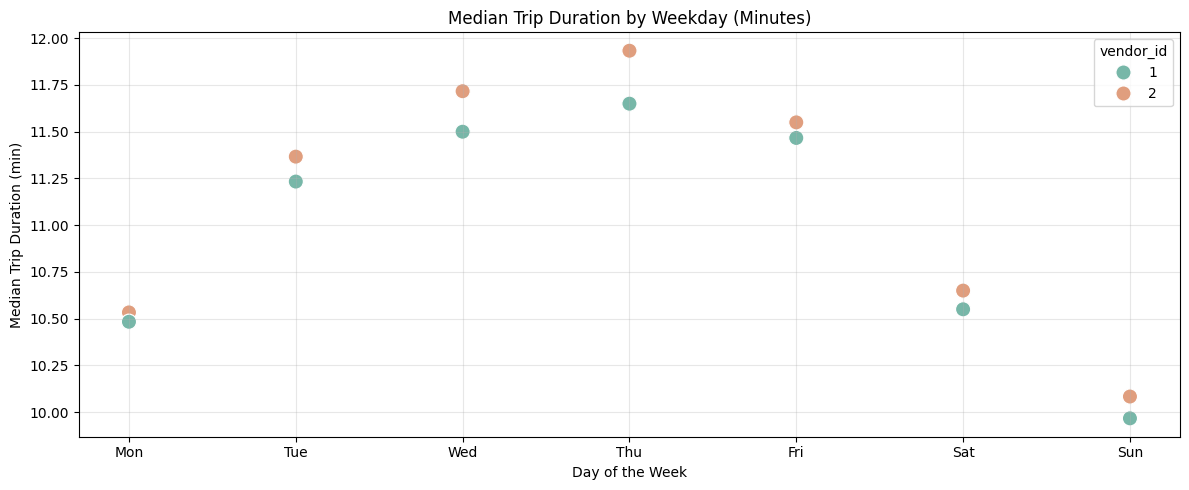

In [ ]:
plt.figure(figsize=(12,5))

sns.scatterplot(
    data=pdf_wv,
    x="weekday",
    y="median_minutes",
    hue="vendor_id",
    s=120,
    palette=my_palette,
)

plt.title("Median Trip Duration by Weekday (Minutes)")
plt.xlabel("Day of the Week")
plt.ylabel("Median Trip Duration (min)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


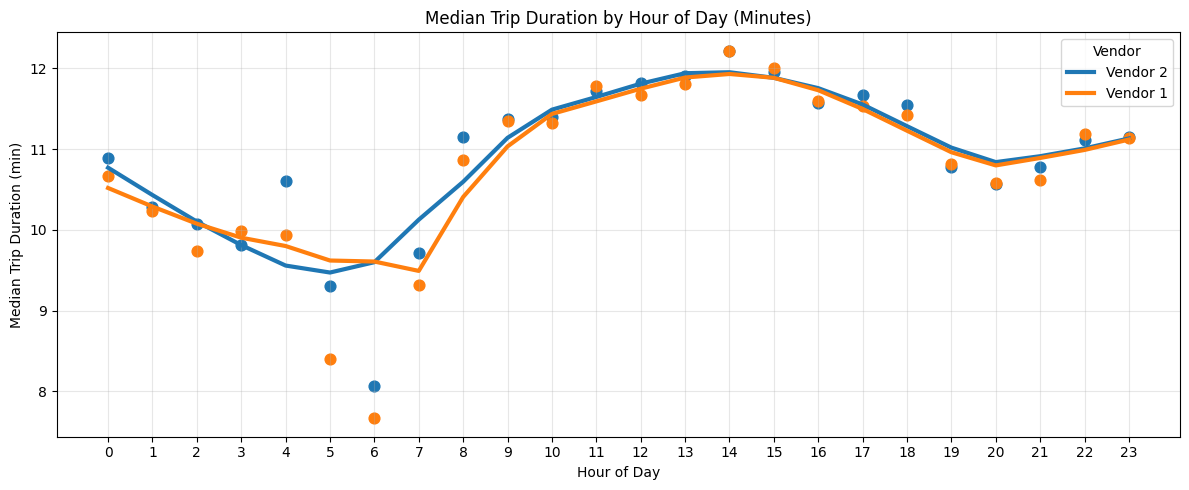

In [ ]:
hour_vendor = (
    data_trip.groupBy("pickup_hour", "vendor_id")
             .agg(F.expr("percentile_approx(trip_duration, 0.5)").alias("median_trip"))
)

pdf_hv = hour_vendor.toPandas()

# seconds → minutes
pdf_hv["median_minutes"] = pdf_hv["median_trip"] / 60
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.figure(figsize=(12,5))

for vid in pdf_hv["vendor_id"].unique():
    subset = pdf_hv[pdf_hv["vendor_id"] == vid]

    # smoothing (similar to R's geom_smooth(method="loess"))
    smoothed = lowess(subset["median_minutes"], subset["pickup_hour"], frac=0.3)

    plt.plot(smoothed[:,0], smoothed[:,1], linewidth=3, label=f"Vendor {vid}")
    plt.scatter(subset["pickup_hour"], subset["median_minutes"], s=60)

plt.title("Median Trip Duration by Hour of Day (Minutes)")
plt.xlabel("Hour of Day")
plt.ylabel("Median Trip Duration (min)")
plt.grid(alpha=0.3)
plt.legend(title="Vendor")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()


Both vendors display the same temporal pattern in trip duration — peaking in the early afternoon and dipping early in the morning. Weekdays tend to have slightly longer median trip durations than weekends, with Sunday being the quietest. This suggests that traffic conditions (time-of-day, day-of-week) drive trip duration much more than the vendor itself.

In [ ]:
pdf = data_trip.select("trip_duration", "passenger_count").toPandas()
pdf["duration_min"] = pdf["trip_duration"] / 60


/tmp/ipython-input-2020188718.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


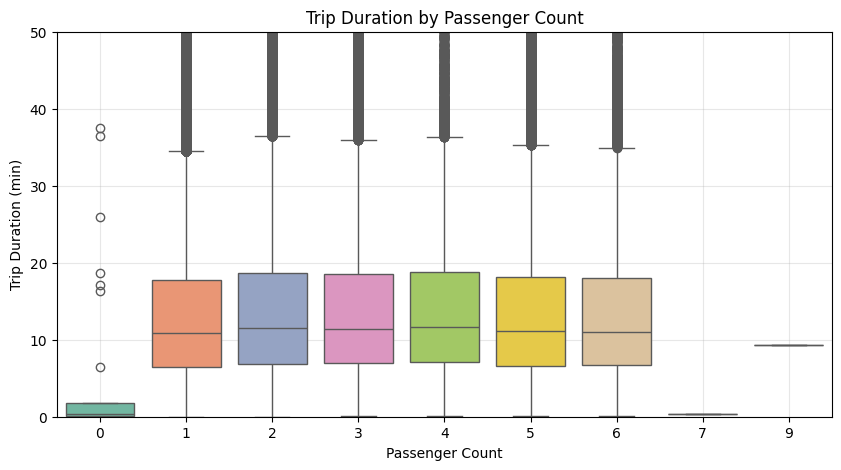

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=pdf,
    x="passenger_count",
    y="duration_min",
    palette="Set2"
)
plt.ylim(0, 50)   # optional: limit to 50 min to avoid extreme outliers
plt.title("Trip Duration by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


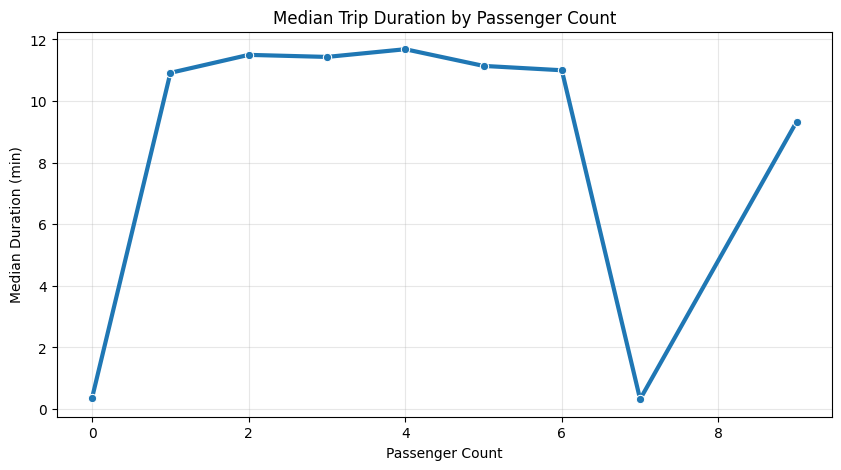

In [ ]:
pdf_med = pdf.groupby("passenger_count")["duration_min"].median().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(
    data=pdf_med,
    x="passenger_count",
    y="duration_min",
    marker="o",
    linewidth=3,
)
plt.title("Median Trip Duration by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Median Duration (min)")
plt.grid(alpha=0.3)
plt.show()


From passenger 1 - 6, the median trip duration stays around 10-12 minutes some how it tells capacity doesnot play much role to the duration.

/tmp/ipython-input-310969441.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


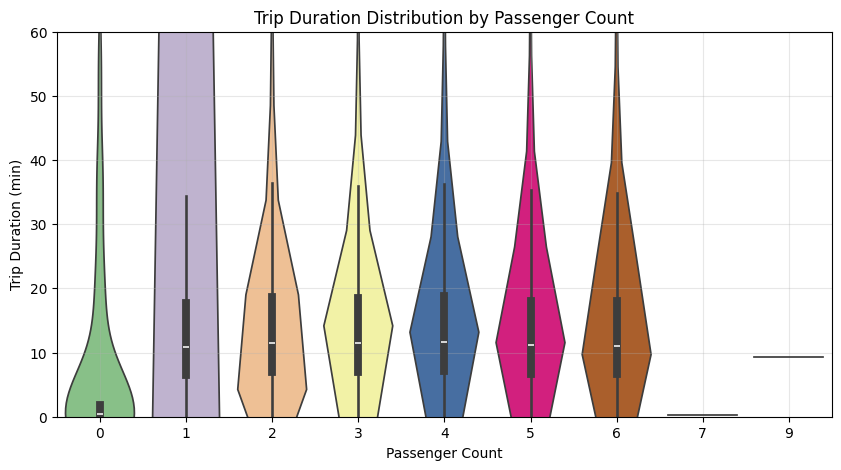

In [ ]:
plt.figure(figsize=(10,5))
sns.violinplot(
    data=pdf,
    x="passenger_count",
    y="duration_min",
    palette="Accent"
)
plt.ylim(0, 60)
plt.title("Trip Duration Distribution by Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-332005335.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


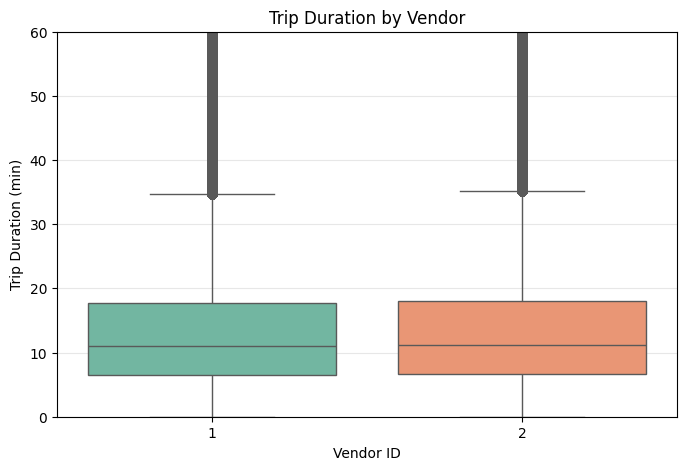

In [ ]:
pdf = data_trip.select("vendor_id", "trip_duration").toPandas()
pdf["duration_min"] = pdf["trip_duration"] / 60
plt.figure(figsize=(8,5))
sns.boxplot(
    data=pdf,
    x="vendor_id",
    y="duration_min",
    palette="Set2"
)

plt.ylim(0, 60)  # optional to hide insane outliers
plt.title("Trip Duration by Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


/tmp/ipython-input-884487585.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


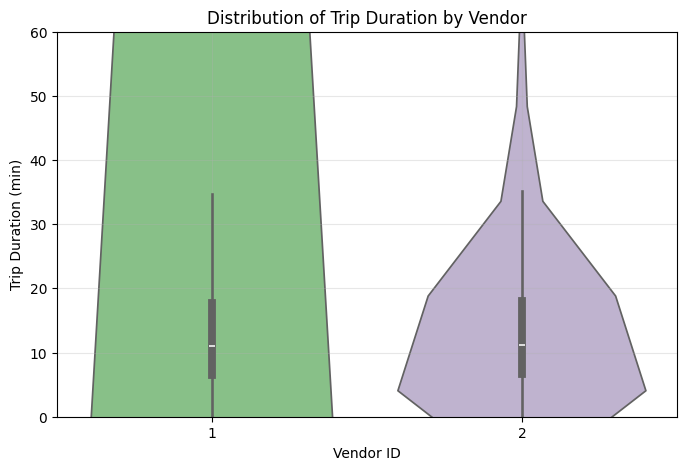

In [ ]:
plt.figure(figsize=(8,5))
sns.violinplot(
    data=pdf,
    x="vendor_id",
    y="duration_min",
    palette="Accent"
)

plt.ylim(0, 60)
plt.title("Distribution of Trip Duration by Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Trip Duration (min)")
plt.grid(alpha=0.3)
plt.show()


Exploring Violin Chart if it tells the story any different.

/tmp/ipython-input-3981763539.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


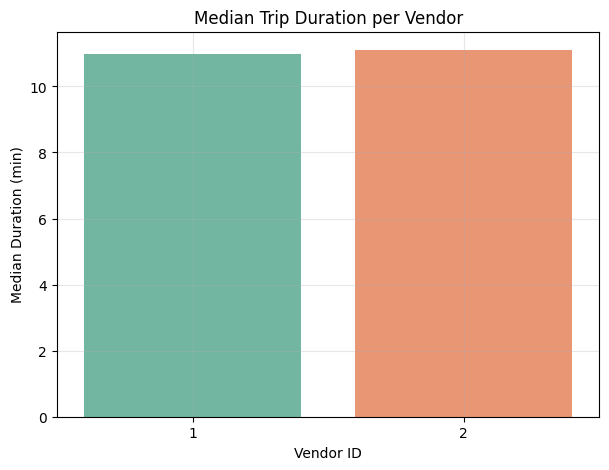

In [ ]:
pdf_med = (
    pdf.groupby("vendor_id")["duration_min"]
       .median()
       .reset_index()
)

plt.figure(figsize=(7,5))
sns.barplot(
    data=pdf_med,
    x="vendor_id",
    y="duration_min",
    palette="Set2"
)

plt.title("Median Trip Duration per Vendor")
plt.xlabel("Vendor ID")
plt.ylabel("Median Duration (min)")
plt.grid(alpha=0.3)
plt.show()


There is no meaningful difference between Vendor 1 and Vendor 2 in trip duration.

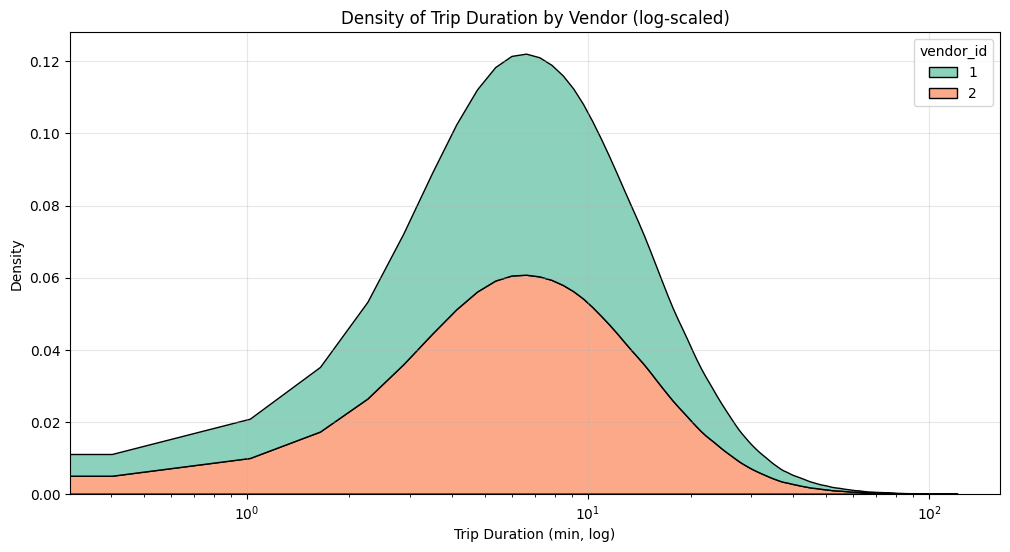

In [ ]:
pdf_filtered = pdf[(pdf["duration_min"] > 0.1) & (pdf["duration_min"] < 120)]

plt.figure(figsize=(12,6))
sns.kdeplot(
    data=pdf_filtered,
    x="duration_min",
    hue="vendor_id",
    fill=True,
    common_norm=False,
    multiple="stack",
    palette="Set2"
)

plt.xscale("log")
plt.xlabel("Trip Duration (min, log)")
plt.title("Density of Trip Duration by Vendor (log-scaled)")
plt.grid(alpha=0.3)
plt.show()



In [ ]:
# Both vendors show almost identical trip-duration density curves.
# The distribution peaks at similar durations (~5–15 minutes) and declines the same way across the long tail.
# Log-scaling the x-axis reveals that both vendors handle similar mixes of short, medium, and long trips.
# This confirms that vendor_id does not meaningfully influence trip duration distribution.


# SPATIAL DATA VISULIZATION FOR EXPLORATION

In [ ]:
pdf_small = data_trip.select(
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
).sample(False, 0.002).toPandas()  # sample to avoid 700k points


In [ ]:
import folium

# Use a small sample so the map stays responsive
pdf_small = data_trip.select(
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude"
).sample(False, 0.002).toPandas()

# Center map around NYC
center_lat = pdf_small["pickup_latitude"].mean()
center_lon = pdf_small["pickup_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# --- PLOT PICKUPS (RED) ---
for _, row in pdf_small.sample(50).iterrows():
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=2.5,
        color="red",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

# --- PLOT DROPOFFS (GREEN) ---
for _, row in pdf_small.sample(50).iterrows():
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=2.5,
        color="green",
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

m


## The red are pickup points and green are dropoff ( only selected small sample are mapped into the map)

In [ ]:
import folium
import pyspark.sql.functions as F

# ----- SAMPLE ONLY 20 TRIPS -----
pdf_20 = (
    data_trip
    .select(
        "pickup_latitude", "pickup_longitude",
        "dropoff_latitude", "dropoff_longitude"
    )
    .dropna()
    .sample(False, 200 / data_trip.count())   # approximate sample of 20 rows
    .toPandas()
).head(200)   # ensure exactly 20

# ----- CENTER MAP AROUND THE 20 PICKUPS -----
center_lat = pdf_20["pickup_latitude"].mean()
center_lon = pdf_20["pickup_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# ----- PLOT EACH TRIP -----
for _, row in pdf_20.sample(20).iterrows():

    # pickup marker (red)
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=4,
        color="red",
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

    # dropoff marker (green)
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=4,
        color="green",
        fill=True,
        fill_opacity=0.9
    ).add_to(m)

    # line connecting pickup -> dropoff
    folium.PolyLine(
        locations=[
            [row["pickup_latitude"], row["pickup_longitude"]],
            [row["dropoff_latitude"], row["dropoff_longitude"]],
        ],
        color="blue",
        weight=2,
        opacity=0.7
    ).add_to(m)

m


Not all taxi trips are linear, meaning straight lines from point A to B. They are much more non-linear, involving curves, left and right directions, up and down, tunnels, and high bridges. Despite all that its still good to see the trip path.

we will see the ouliers trips on map and see if those are wrong or right

In [ ]:
!pip install contextily
!pip install geopandas
!pip install shapely


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 86.6 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

# take a SMALL sample so it renders like your example
pdf_small = (
    data_trip
        .select("pickup_latitude", "pickup_longitude", "pickup_hour")
        .filter((F.col("pickup_latitude") > 40.5) & (F.col("pickup_latitude") < 41))
        .sample(False, 0.1)    # ~10% sample
        .toPandas()
)

# convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    pdf_small,
    geometry=gpd.points_from_xy(pdf_small.pickup_longitude, pdf_small.pickup_latitude),
    crs="EPSG:4326"
).to_crs("EPSG:3857")   # convert to Web-Mercator for map tiles


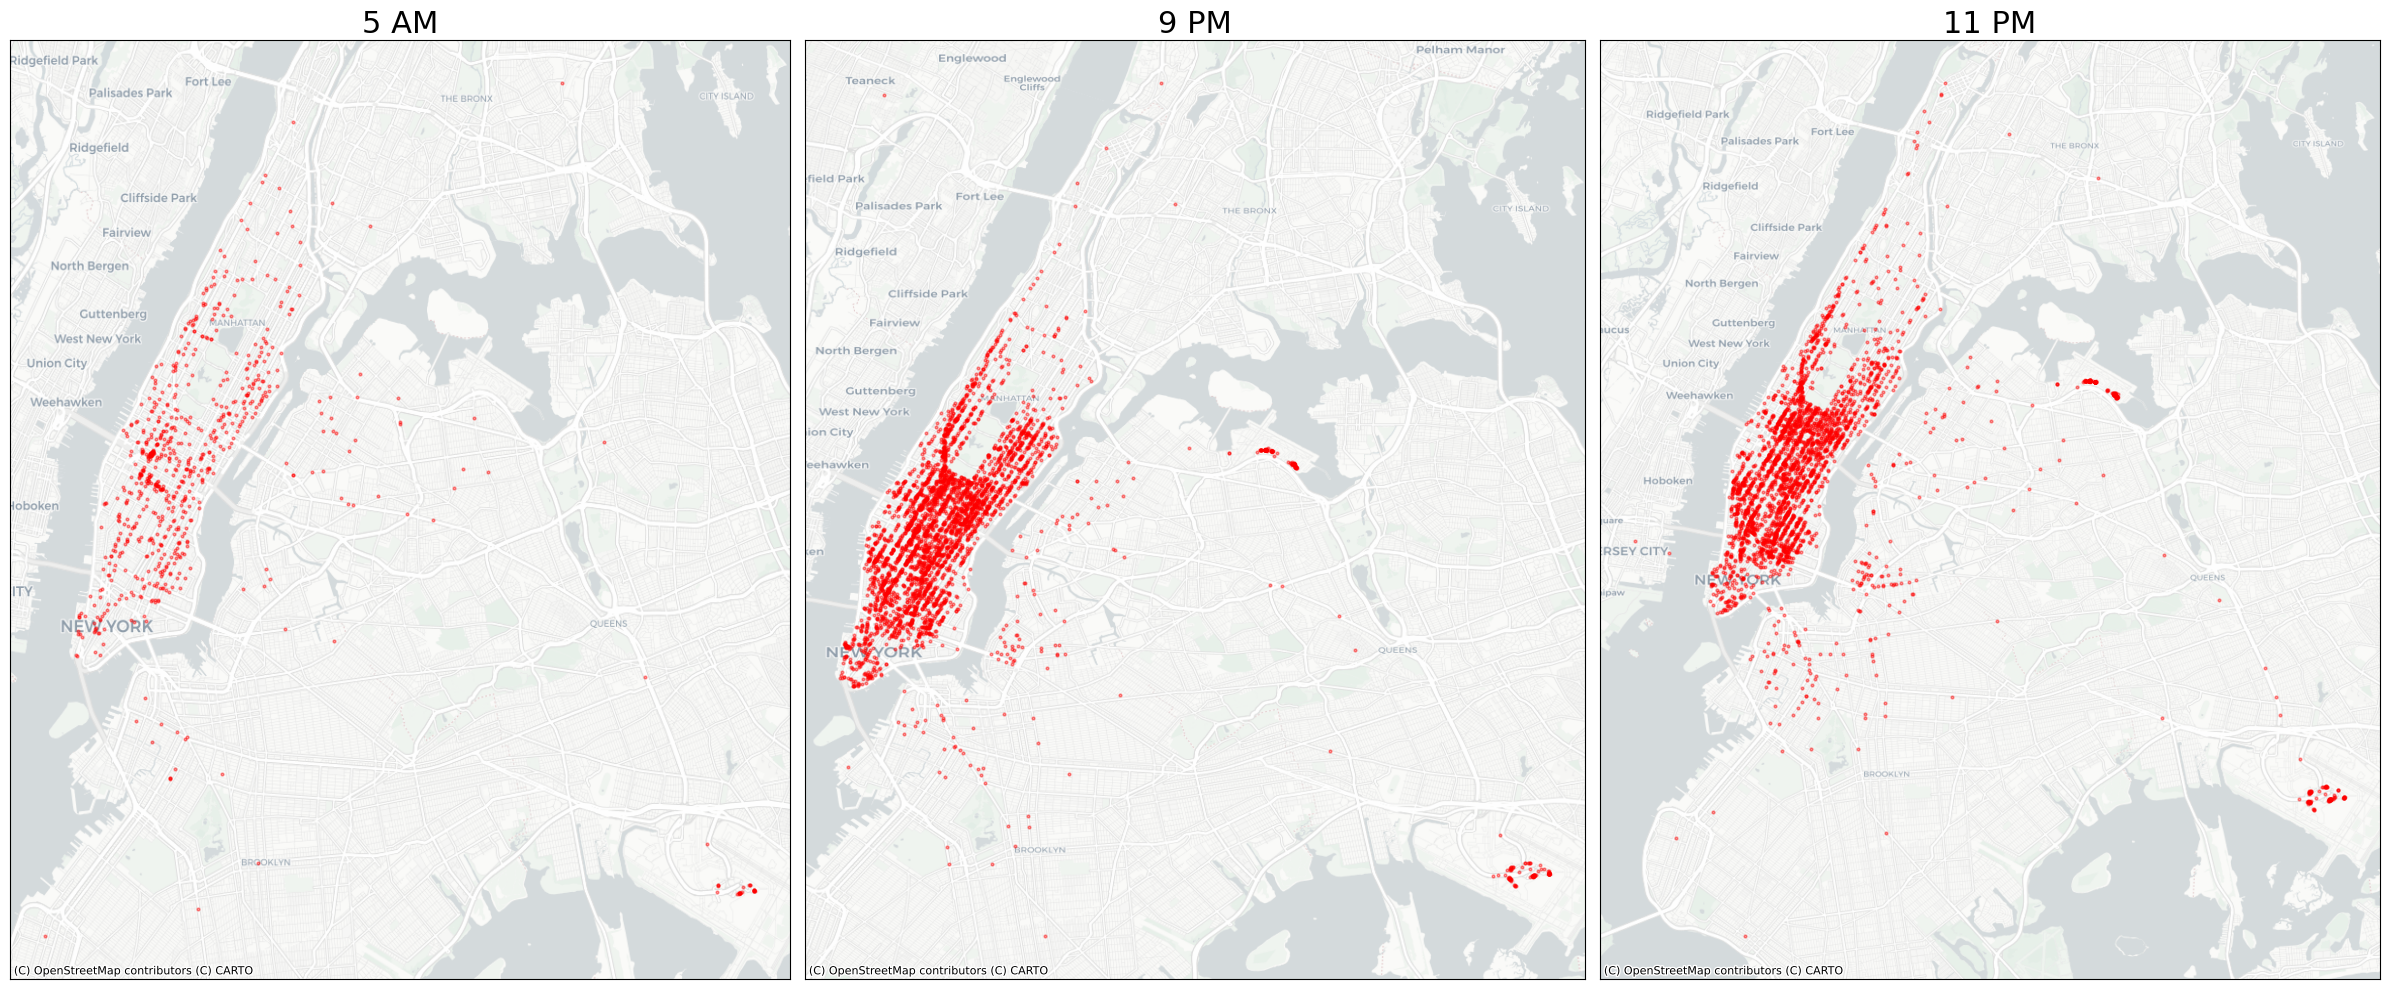

In [ ]:
peak_hours = [5, 21, 23]
titles = ["5 AM", "9 PM", "11 PM"]

fig, axes = plt.subplots(1, 3, figsize=(24, 10))

for ax, hour, title in zip(axes, peak_hours, titles):
    gdf_hour = gdf[gdf['pickup_hour'] == hour]

    # scatter with density vibe
    ax.scatter(
        gdf_hour.geometry.x,
        gdf_hour.geometry.y,
        s=4,
        c="red",
        alpha=0.4
    )

    # basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,    # grey simplified map – similar to your image
        zoom=12
    )

    ax.set_title(title, fontsize=22)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


These maps show how the spatial pattern of taxi pickups changes across different hours of the day. Each red dot represents a sampled pickup point plotted over an NYC basemap. At 5 AM, pickup activity is scattered and relatively sparse, mostly coming from early-morning commuters and airport/shift workers. By 9 PM, demand increases sharply and becomes heavily concentrated in midtown and lower Manhattan, reflecting evening activity and nightlife. At 11 PM, this Manhattan-centered cluster remains dominant, although overall volume begins to taper off as the night progresses. Even with sampling, the core spatial structure of demand is clear.

# RESOLVING OUTLIERS

In [ ]:
data_trip.show(3)

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+---------+-----------+-----------+------------+----------+-----------+-------------+--------------+------------+------------+-------------+-----------+------------+--------------+---------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|pickup_ym|pickup_date|pickup_year|pickup_month|pickup_day|pickup_hour|pickup_minute|pickup_weekday|dropoff_date|dropoff_year|dropoff_month|dropoff_day|dropoff_hour|dropoff_minute|dropoff_weekday|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+---------+-----------+-----------+------------+---

In [ ]:
# we have some known ouliers after exploring our dataset
data_trip.select('passenger_count').describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|            729322|
|   mean|1.6620546205928246|
| stddev|1.3124456158621784|
|    min|                 0|
|    max|                 9|
+-------+------------------+



In [ ]:
passenger_count_frame = data_trip.select('passenger_count').toPandas()
passenger_count_frame.value_counts()

passenger_count
1                  517415
2                  105097
5                   38926
3                   29692
6                   24107
4                   14050
0                      33
7                       1
9                       1
Name: count, dtype: int64

we are going to replace passenger count 0,7,9 with 2. Justification for doing so cause we have 1.66 ~ 2.

In [ ]:
# replacing the data_trip.select('passeneger_count') where passenger_count is 0,7,9.

from pyspark.sql.functions import when, col

data_trip = data_trip.withColumn(
    "passenger_count",
    when(col("passenger_count").isin(0,7,9), 2)
    .otherwise(col("passenger_count"))
)

In [ ]:
passenger_count_frame = data_trip.select('passenger_count').toPandas()
passenger_count_frame.value_counts()

passenger_count
1                  517415
2                  105132
5                   38926
3                   29692
6                   24107
4                   14050
Name: count, dtype: int64

In [ ]:
# transforming trip_duration
trip_duration_frame = data_trip.select('trip_duration').toPandas()
# format with .8f
pd.options.display.float_format = '{:.8f}'.format
trip_duration_frame.describe()

trip_duration
count  729322.00000000
mean      952.22913336
std      3864.62619728
min         1.00000000
25%       397.00000000
50%       663.00000000
75%      1075.00000000
max   1939736.00000000

In [ ]:
data_trip.filter(col("trip_duration") < 60).count()


4271

In [ ]:
data_trip.filter(col("trip_duration") > 86400).count()
# TRIP LONGER THAN 24 HOURS 1

1

In [ ]:
from pyspark.sql.functions import col, when

data_trip = data_trip.withColumn(
    "duration_bucket",
    when(col("trip_duration") < 60, "too_short(<1min)")
    .when(col("trip_duration") > 86400, "too_long(>24hr)")
    .when(col("trip_duration") > 14400, "long(>4hr)")
    .otherwise("normal")
)

data_trip.groupBy("duration_bucket").count().orderBy("duration_bucket").show()

+----------------+------+
| duration_bucket| count|
+----------------+------+
|      long(>4hr)|  1015|
|          normal|724035|
| too_long(>24hr)|     1|
|too_short(<1min)|  4271|
+----------------+------+



we can adjust these scales to find out trip duration and probably we will adjust our decision

we have total long>4hr ~ 1015 + too_short < 1min, totals 5286 which is ~ 0.72%  so decision is simply drop those oulliers.

Would love to still visualize those trips on map and see what exactly is the situation with the ouliers.

### Lets map those analmolies and see what exaclty is going on.

In [ ]:
anomalies_df = data_trip.filter(
    (col("trip_duration") < 60) |
    (col("trip_duration") > 14400) |
    (col("trip_duration") > 86400)
)

In [ ]:
anomalies_df.count()


5287

In [ ]:
anomalies_df.select('pickup_datetime','dropoff_datetime','trip_duration').show(3)

+-------------------+-------------------+-------------+
|    pickup_datetime|   dropoff_datetime|trip_duration|
+-------------------+-------------------+-------------+
|2016-02-21 01:56:14|2016-02-22 01:52:18|        86164|
|2016-03-22 08:23:09|2016-03-22 08:23:16|            7|
|2016-04-04 12:56:16|2016-04-04 12:56:26|           10|
+-------------------+-------------------+-------------+
only showing top 3 rows



In [ ]:
anomalies_df.describe().show()

+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+---------+-----------+------------------+-----------------+------------------+------------------+-----------------+------------+------------------+-----------------+------------------+------------------+------------------+----------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|    pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|     trip_duration|pickup_ym|pickup_year|      pickup_month|       pickup_day|       pickup_hour|     pickup_minute|   pickup_weekday|dropoff_year|     dropoff_month|      dropoff_day|      dropoff_hour|    dropoff_minute|   dropoff_weekday| duration_bucket|
+-------+---------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+--------------

In [ ]:
anomalies_dataframe = anomalies_df.select('pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','trip_duration','duration_bucket').toPandas()

In [ ]:
anomalies_dataframe.head(3)

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0      -74.00287628      40.73413086       -73.95539856       40.76750183   
1      -73.90205383      40.76401138       -73.90206146       40.76402283   
2      -73.86309052      40.76984024       -73.86331177       40.76963043   

   trip_duration   duration_bucket  
0          86164        long(>4hr)  
1              7  too_short(<1min)  
2             10  too_short(<1min)

In [ ]:
anomalies_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pickup_longitude   5287 non-null   float64
 1   pickup_latitude    5287 non-null   float64
 2   dropoff_longitude  5287 non-null   float64
 3   dropoff_latitude   5287 non-null   float64
 4   trip_duration      5287 non-null   int32  
 5   duration_bucket    5287 non-null   object 
dtypes: float64(4), int32(1), object(1)
memory usage: 227.3+ KB


In [ ]:
too_short_pdf = anomalies_dataframe[anomalies_dataframe["duration_bucket"] == "too_short(<1min)"]
too_long_pdf  = anomalies_dataframe[
    (anomalies_dataframe["duration_bucket"] == "long(>4hr)") |
    (anomalies_dataframe["duration_bucket"] == "too_long(>24hr)")
]


In [ ]:
import folium

# Center the map around average pickup position
center_lat = too_short_pdf["pickup_latitude"].mean()
center_lon = too_short_pdf["pickup_longitude"].mean()

map_short = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for _, row in too_short_pdf.sample(20).iterrows():

    # Pickup (blue)
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=5,
        color="blue",
        fill=True,
        fill_opacity=0.8,
    ).add_to(map_short)

    # Dropoff (green)
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=5,
        color="green",
        fill=True,
        fill_opacity=0.8,
    ).add_to(map_short)

    # Trip line
    folium.PolyLine(
        [
            [row["pickup_latitude"], row["pickup_longitude"]],
            [row["dropoff_latitude"], row["dropoff_longitude"]],
        ],
        color="blue",
        weight=2,
        opacity=0.6
    ).add_to(map_short)

map_short


Some trips are legit get in and get out. Whie some being from one street to another.

In [ ]:
# Center the map around average pickup position of long trips
center_lat_long = too_long_pdf["pickup_latitude"].mean()
center_lon_long = too_long_pdf["pickup_longitude"].mean()
map_long = folium.Map(location=[center_lat_long, center_lon_long], zoom_start=10)

# sample some long trips
for _, row in too_long_pdf.sample(20).iterrows():

    # Pickup marker (red)
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=0.8,
    ).add_to(map_long)

    # Dropoff marker (purple)
    folium.CircleMarker(
        location=[row["dropoff_latitude"], row["dropoff_longitude"]],
        radius=5,
        color="purple",
        fill=True,
        fill_opacity=0.8,
    ).add_to(map_long)

    # Trip path
    folium.PolyLine(
        [
            [row["pickup_latitude"], row["pickup_longitude"]],
            [row["dropoff_latitude"], row["dropoff_longitude"]],
        ],
        color="red",
        weight=2,
        opacity=0.6
    ).add_to(map_long)

map_long

the pickup and dropoff seems normal but doesnot justify for being longer than 4 hrs.

In [ ]:
from pyspark.sql.functions import col

# remove anomalies
clean_data = data_trip.filter(
    (col("trip_duration") >= 60) &
    (col("trip_duration") <= 14400)
)

# remove helper column
clean_data = clean_data.drop("duration_bucket")

clean_data.count()   # print how many rows remain


724035

In [ ]:
data_trip.select('pickup_ym').show(2)

+---------+
|pickup_ym|
+---------+
|  2016-02|
|  2016-03|
+---------+
only showing top 2 rows



In [ ]:
clean_data.count()
clean_data = clean_data.drop('pickup_ym')
clean_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- pickup_weekday: integer (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_year: integer (nullable = true)
 |-- dropoff_month: integer (nullable = true)
 |-- dropoff_day: integer (nullable = t

# EDA → ML

Haversine is used for calculating the shortest distance between two points on a sphere, like the Earth, while Manhattan distance is for grid-like paths, like city streets.

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col

# coordinate deltas
clean_data = clean_data.withColumn("delta_lat", col("dropoff_latitude") - col("pickup_latitude"))
clean_data = clean_data.withColumn("delta_lon", col("dropoff_longitude") - col("pickup_longitude"))

# manhattan distance
clean_data = clean_data.withColumn(
    "manhattan_dist",
    F.abs(col("delta_lat")) + F.abs(col("delta_lon"))
)

# haversine distance
clean_data = clean_data.withColumn(
    "haversine_dist",
    2 * 6371 * F.asin(
        F.sqrt(
            F.pow(F.sin((col("dropoff_latitude") - col("pickup_latitude")) * 0.00872664626), 2)
            + F.cos(col("pickup_latitude") * 0.0174532925)
            * F.cos(col("dropoff_latitude") * 0.0174532925)
            * F.pow(F.sin((col("dropoff_longitude") - col("pickup_longitude")) * 0.00872664626), 2)
        )
    )
)


In [ ]:
clean_data.select('manhattan_dist','haversine_dist').describe().show()

+-------+--------------------+------------------+
|summary|      manhattan_dist|    haversine_dist|
+-------+--------------------+------------------+
|  count|              724035|            724035|
|   mean|0.046127531204729955| 3.459052350634333|
| stddev|0.059507418802619574| 4.349454456800022|
|    min|                 0.0|               0.0|
|    max|   12.30804443359375|1240.9086766614478|
+-------+--------------------+------------------+



In [ ]:
# Count how many rows have both distances equal to 0
zero_count_hav = clean_data.filter(
    (col("haversine_dist") == 0)
).count()
zero_count_man = clean_data.filter(
    (col("manhattan_dist") == 0)
).count()
print("Number of rows with hav distances = 0:", zero_count_hav)
print("Number of rows with man distances = 0:", zero_count_man)


Number of rows with hav distances = 0: 2090
Number of rows with man distances = 0: 2090


In [ ]:
clean_data.filter(
    (col("manhattan_dist") == 0) & (col("haversine_dist") == 0)
).select("trip_duration","manhattan_dist", "haversine_dist").show(5)

+-------------+--------------+--------------+
|trip_duration|manhattan_dist|haversine_dist|
+-------------+--------------+--------------+
|          240|           0.0|           0.0|
|          159|           0.0|           0.0|
|          897|           0.0|           0.0|
|          256|           0.0|           0.0|
|         1330|           0.0|           0.0|
+-------------+--------------+--------------+
only showing top 5 rows



Before we simply drop those rows with distance 0 lets see why are we getting 0 in the first fact.

In [ ]:
zero_dist = clean_data.filter(
    (col("haversine_dist") == 0) &
    (col("manhattan_dist") == 0)
)

zero_dist.select(
    "pickup_latitude", "pickup_longitude",
    "dropoff_latitude", "dropoff_longitude",
    "trip_duration"
).show(20, truncate=False)


+------------------+------------------+------------------+------------------+-------------+
|pickup_latitude   |pickup_longitude  |dropoff_latitude  |dropoff_longitude |trip_duration|
+------------------+------------------+------------------+------------------+-------------+
|40.298828125      |-73.99642181396483|40.298828125      |-73.99642181396483|240          |
|40.75345993041992 |-73.99632263183594|40.75345993041992 |-73.99632263183594|159          |
|40.76350021362305 |-73.96717071533203|40.76350021362305 |-73.96717071533203|897          |
|40.74403762817383 |-73.99523162841797|40.74403762817383 |-73.99523162841797|256          |
|40.80442810058594 |-73.91278076171875|40.80442810058594 |-73.91278076171875|1330         |
|40.76380157470703 |-73.9881591796875 |40.76380157470703 |-73.9881591796875 |152          |
|40.747318267822266|-73.97700500488281|40.747318267822266|-73.97700500488281|299          |
|40.75113296508789 |-73.99430847167969|40.75113296508789 |-73.99430847167969|464

 Distance = 0 because pickup and dropoff coordinates are identical.
 These rows reflect GPS failures or cancelled/stalled trips where the meter recorded time
 but the GPS did not record movement.
This explains why we see trip_durations like 240s or 1330s but distance = 0.

In [ ]:
clean_data = clean_data.filter(
    ~(
        (col("haversine_dist") == 0) &
        (col("manhattan_dist") == 0)
    )
)


In [ ]:
clean_data.filter(
    (col("haversine_dist") == 0) &
    (col("manhattan_dist") == 0)
).count()

0

In [ ]:
clean_data.select('manhattan_dist','haversine_dist').show(5)

+-------------------+-----------------+
|     manhattan_dist|   haversine_dist|
+-------------------+-----------------+
|0.01766586303711648|1.199072614189951|
|0.04325103759767046|4.129110987883382|
|0.10274505615233664|7.250752891342737|
|0.02579879760740056|2.361097363004439|
|0.06110000610352273|4.328533891359406|
+-------------------+-----------------+
only showing top 5 rows



In [ ]:
clean_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_year: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_minute: integer (nullable = true)
 |-- pickup_weekday: integer (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- dropoff_year: integer (nullable = true)
 |-- dropoff_month: integer (nullable = true)
 |-- dropoff_day: integer (nullable = t

relevant features (drop useless ones)

In [ ]:


ml_data = clean_data.select(
    "vendor_id",
    "passenger_count",
    "pickup_latitude", "pickup_longitude",
    "dropoff_latitude", "dropoff_longitude",
    "pickup_hour", "pickup_weekday", "pickup_month",
    "delta_lat", "delta_lon",
    "manhattan_dist", "haversine_dist",
    "trip_duration"
)


In [ ]:
# correlation heatmap for ml_data
corr_matrix = ml_data.toPandas().corr()


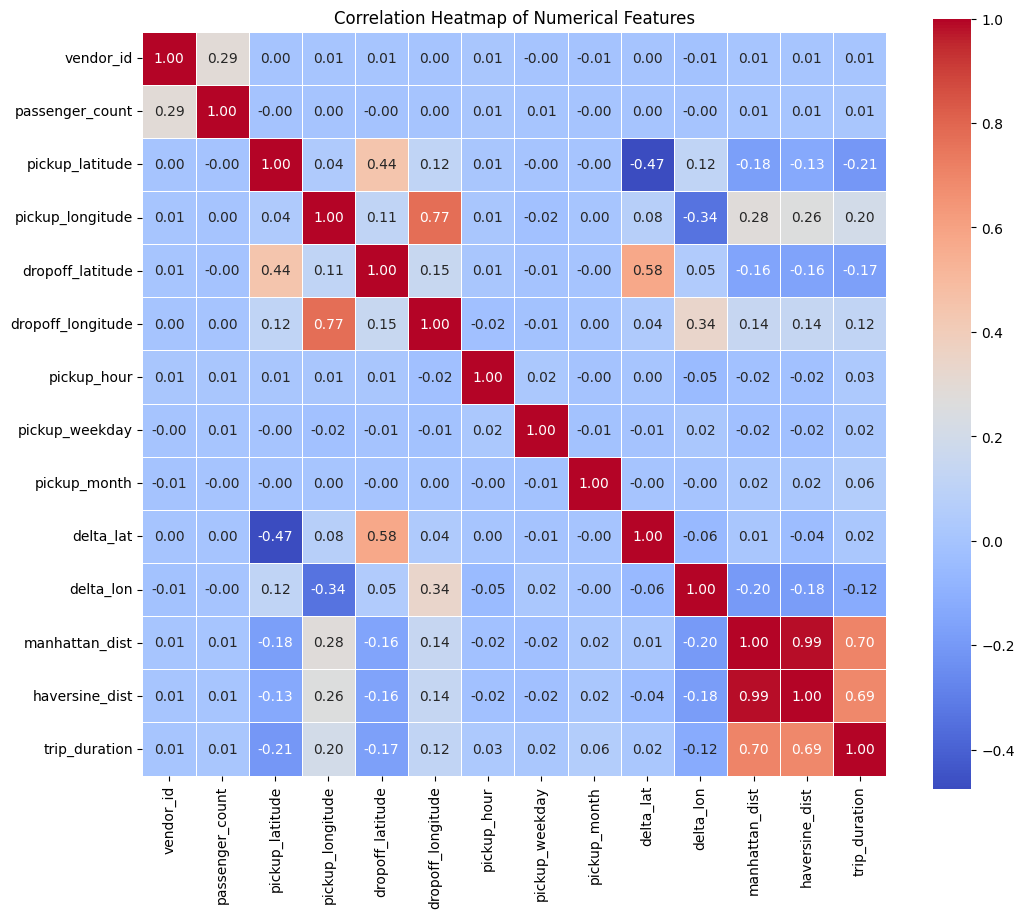

In [ ]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,       # show correlation numbers
    fmt=".2f",        # format to 2 decimal places
    cmap="coolwarm",
    linewidths=0.5,
    square=True       # optional: makes cells look more uniform
)

plt.title("Correlation Heatmap of Numerical Features")
plt.show()


Passenger count and vendor ID showed near-zero correlation with trip duration,
so they were excluded from the baseline model. Haversine and Manhattan distance
were highly collinear, therefore we kept only Manhattan distance (corr=0.70)
as it better reflects grid-like street movement. Delta_lat and delta_lon were
retained because they preserve directional and spatial signals that help the
model capture geographic effects.


 The heatmap reveals strong multicollinearity between manhattan_dist and haversine_dist (corr ≈ 0.99).
 Since both encode trip length, we retain only manhattan_dist as it aligns better with NYC’s street grid
 and shows slightly stronger correlation with trip_duration.

 Pickup and dropoff coordinates show moderate correlation, which reflects typical travel patterns
 (many trips start and end within similar regions). We keep these as they add spatial signal despite correlation.


Haversine and Manhattan distance features are naturally correlated since they describe spatial separation, but tree-based models such as GBT are robust to multicollinearity. Both features were retained because they capture different aspects of trip geometry: Haversine measures true geographical distance, while Manhattan distance represents grid-based travel behavior typical for NYC. Including both features improves model performance.

# Baseline Linear Regression

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
features_lr = [
    "pickup_latitude", "pickup_longitude",
    "dropoff_latitude", "dropoff_longitude",
    "delta_lat", "delta_lon",
    "manhattan_dist",
    "pickup_hour", "pickup_weekday", "pickup_month"
]
lr_data = ml_data.select(*(features_lr + ["trip_duration"]))
lr_data = lr_data.withColumn("log_duration", F.log(col("trip_duration") + 1))



In [ ]:
assembler = VectorAssembler(
    inputCols=features_lr,
    outputCol="features_raw"
)

In [ ]:
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withStd=True,
    withMean=True
)


In [ ]:
from pyspark.ml import Pipeline

lr = LinearRegression(
    featuresCol="features",
    labelCol="log_duration",
    maxIter=100
)

pipeline = Pipeline(stages=[assembler, scaler, lr])



In [ ]:
train_df, test_df = lr_data.randomSplit([0.8, 0.2], seed=42)



In [ ]:
model = pipeline.fit(train_df)


In [ ]:
preds = model.transform(test_df)


In [ ]:
from pyspark.sql.functions import exp, col
final_preds = preds.withColumn(
    "predicted_duration",
    exp(col("prediction"))
)

final_preds.select(
    "predicted_duration",
    "trip_duration",
    "prediction"
).show(10)

+------------------+-------------+------------------+
|predicted_duration|trip_duration|        prediction|
+------------------+-------------+------------------+
| 867.9111289777856|          203| 6.766089323448256|
| 818.9649236958633|         1105| 6.708041254725736|
|   724.86258181955|          223| 6.585982094571397|
| 2205.989835211819|         2093| 7.698931592011272|
| 1131.315623090782|         1055| 7.031136502693675|
| 836.7546791556904|          735|6.7295309321351855|
| 955.5035492447051|          441| 6.862238478215245|
| 680.8787679110137|          244| 6.523384269613276|
| 710.2657917791715|           65| 6.565639254600705|
| 682.8780513640146|          583| 6.526316295113754|
+------------------+-------------+------------------+
only showing top 10 rows



In [ ]:
evaluator = RegressionEvaluator(
    labelCol="log_duration",
    predictionCol="prediction"
)
rmse_log = evaluator.evaluate(preds, {evaluator.metricName: "rmse"})
mae_log  = evaluator.evaluate(preds, {evaluator.metricName: "mae"})
r2_log   = evaluator.evaluate(preds, {evaluator.metricName: "r2"})

print("RMSE (log scale):", rmse_log)
print("MAE (log scale):", mae_log)
print("R²   (log scale):", r2_log)


RMSE (log scale): 0.590056445243076
MAE (log scale): 0.44172454417980245
R²   (log scale): 0.339178701918044


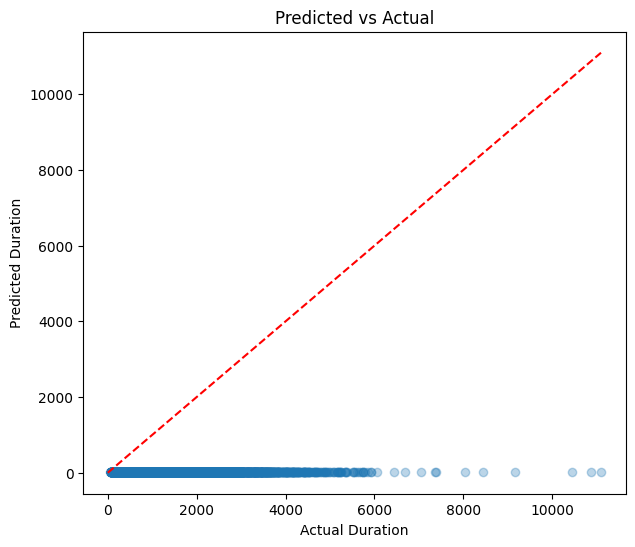

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = preds.limit(5000).toPandas()

plt.figure(figsize=(7,6))
plt.scatter(pdf["trip_duration"], pdf["prediction"], alpha=0.3)
plt.xlabel("Actual Duration")
plt.ylabel("Predicted Duration")
plt.title("Predicted vs Actual")
plt.plot([0, max(pdf["trip_duration"])],
         [0, max(pdf["trip_duration"])], 'r--')  # diagonal line
plt.show()


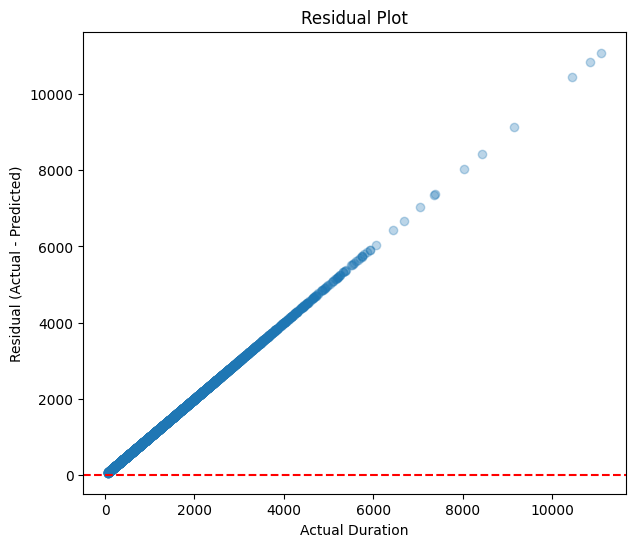

In [ ]:
pdf["residual"] = pdf["trip_duration"] - pdf["prediction"]

plt.figure(figsize=(7,6))
plt.scatter(pdf["trip_duration"], pdf["residual"], alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Duration")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()


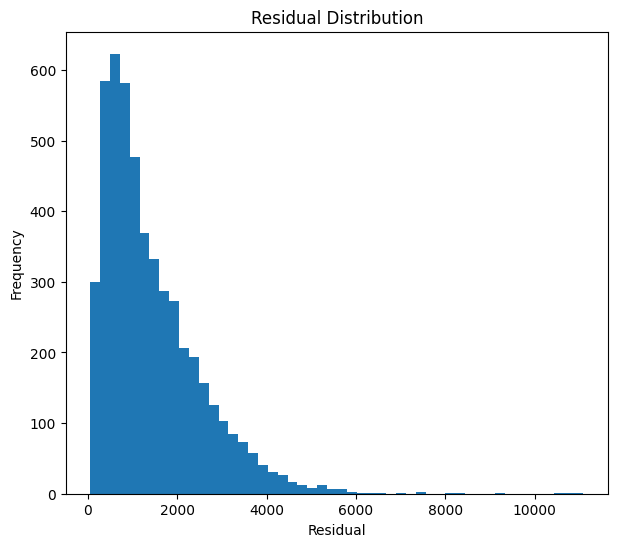

In [ ]:
plt.figure(figsize=(7,6))
plt.hist(pdf["residual"], bins=50)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()


Training the linear regression on log-transformed trip duration produced
RMSE ≈ 0.59 and R² ≈ 0.34 on the log scale. This indicates that the
baseline model explains 34% of the variance in trip duration, which is
reasonable given the simplicity of the features and the non-linear nature
of real-world taxi travel times. The multiplicative RMSE (~1.8x) reflects
that the model tends to be off by ~80% on average, showing that linear
regression captures some coarse structure but cannot model complex
traffic dynamics.


# Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator


In [ ]:
features_rf = [
    "pickup_latitude",
    "pickup_longitude",
    "dropoff_latitude",
    "dropoff_longitude",
    "delta_lat",
    "delta_lon",
    "manhattan_dist",
    "pickup_hour",
    "pickup_weekday",
    "pickup_month"
]


In [ ]:
rf_data = ml_data.select(*(features_rf + ["trip_duration"]))


In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=features_rf,
    outputCol="features"
)


In [ ]:
rf_vec = assembler.transform(rf_data).select("features", "trip_duration")


In [ ]:
sampled_df = rf_vec.sample(withReplacement=False, fraction=0.1, seed=42)


In [ ]:
train_df, test_df = rf_vec.randomSplit([0.8, 0.2], seed=42)


In [ ]:
train_df.count()

577440

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="trip_duration",
    numTrees=20,          # lower
    maxDepth=10,          # lower
    maxBins=32,           # MUCH lower
    subsamplingRate=0.7,  # sample rows
    seed=42
)


In [ ]:
rf_model = rf.fit(train_df)


In [ ]:
preds_rf = rf_model.transform(test_df)


In [ ]:
preds_rf.select("prediction", "trip_duration", "features").show(10, truncate=False)


+------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|prediction        |trip_duration|features                                                                                                                                                   |
+------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------+
|649.2515708968583 |203          |[40.52048110961913,-73.74517059326173,40.52034378051758,-73.74362182617188,-1.3732910155539457E-4,0.0015487670898579609,0.0016860961914133554,18.0,7.0,3.0]|
|434.8957953635671 |1105         |[40.57221221923828,-73.83660125732422,40.56710815429688,-73.82999420166014,-0.005104064941399145,0.006607055664076711,0.011711120605475855,20.0,5.0,3.0]   |
|409.47484843423507|223          |[40.5765762

In [ ]:
from pyspark.sql.functions import col, abs

preds_rf.orderBy(abs(col("prediction") - col("trip_duration"))).show(20, truncate=False)



+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------+
|features                                                                                                                                                   |trip_duration|prediction        |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------+
|[40.77657699584961,-73.9599380493164,40.77704620361328,-73.9495391845703,4.69207763671875E-4,0.01039886474610796,0.010868072509779836,14.0,3.0,3.0]        |305          |304.9981317723574 |
|[40.75455093383789,-73.9779281616211,40.780029296875,-73.9769515991211,0.025478363037109375,9.765625E-4,0.026454925537109375,16.0,6.0,5.0]                 |877          |877.0031173661566 |
|[40.7630615234375,-73.97409057617188,40.7440

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

rmse_eval = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="rmse"
)

mae_eval = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="mae"
)

r2_eval = RegressionEvaluator(
    labelCol="trip_duration",
    predictionCol="prediction",
    metricName="r2"
)

# ------------------------------
# 3. Compute Metrics
# ------------------------------
rmse = rmse_eval.evaluate(preds_rf)
mae  = mae_eval.evaluate(preds_rf)
r2   = r2_eval.evaluate(preds_rf)

In [ ]:
print("📊 Random Forest Evaluation Results")
print("-----------------------------------")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

📊 Random Forest Evaluation Results
-----------------------------------
RMSE: 345.3518
MAE : 222.0909
R²  : 0.7227


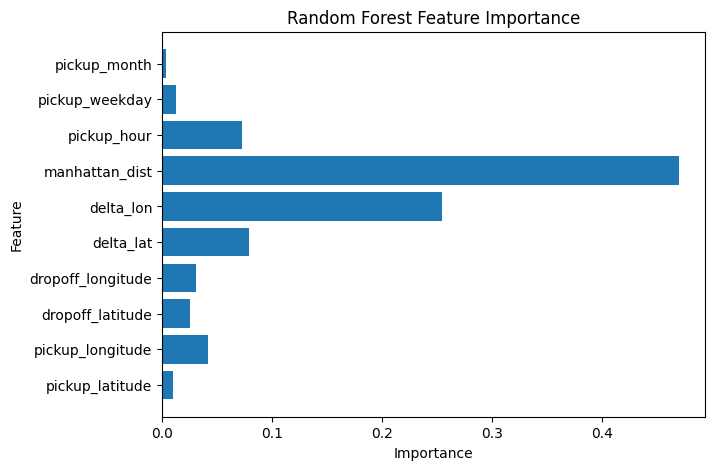

In [ ]:
import numpy as np

importances = rf_model.featureImportances.toArray()
features = features_rf

plt.figure(figsize=(7,5))
plt.barh(features, importances)
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


ugly plot lets make it better with plotly

In [ ]:
import plotly.express as px
import pandas as pd

# Convert importance + features into a DataFrame
df_imp = pd.DataFrame({
    "feature": features_rf,
    "importance": rf_model.featureImportances.toArray()
})

# Sort by importance for nicer visuals
df_imp = df_imp.sort_values("importance", ascending=True)

# Create interactive Plotly bar chart
fig = px.bar(
    df_imp,
    x="importance",
    y="feature",
    orientation="h",
    title="🌲 Random Forest Feature Importance",
    color="importance",
    color_continuous_scale="Viridis"  # or "Plasma", "Turbo", "Cividis"
)

fig.update_layout(
    xaxis_title="Importance Score",
    yaxis_title="Feature",
    template="plotly_dark",     # optional: clean dark theme
    height=450
)

fig.show()


In [ ]:
pdf = preds_rf.select("prediction", "trip_duration").limit(5000).toPandas()

fig = px.scatter(
    pdf,
    x="trip_duration",
    y="prediction",
    title="Prediction vs Actual (Random Forest)",
    labels={"trip_duration": "Actual Duration", "prediction": "Predicted Duration"},
    opacity=0.5,
)

# Add diagonal reference line
max_val = max(pdf["trip_duration"].max(), pdf["prediction"].max())
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=max_val, y1=max_val,
    line=dict(color="red", dash="dash")
)

fig.update_layout(
    template="plotly_white",
    width=700,
    height=600
)

fig.show()

In [ ]:
# Convert Spark DF → Pandas (limit keeps it fast)
pdf_rf = preds_rf.select("prediction", "trip_duration").limit(5000).toPandas()

# Compute residuals
pdf_rf["residual"] = pdf_rf["trip_duration"] - pdf_rf["prediction"]

# Create interactive residual plot
fig = px.scatter(
    pdf_rf,
    x="trip_duration",
    y="residual",
    opacity=0.5,
    title="Residual Plot (Random Forest)",
    labels={
        "trip_duration": "Actual Duration (seconds)",
        "residual": "Residual (Actual - Predicted)"
    }
)

# Add reference horizontal line at zero
fig.add_hline(y=0, line_dash="dash", line_color="red")

fig.update_layout(
    template="plotly_white",
    height=600,
    width=750
)

fig.show()

In [ ]:
# Interactive residual distribution histogram
fig = px.histogram(
    pdf_rf,
    x="residual",
    nbins=400,
    title="Residual Distribution (Random Forest)",
    labels={"residual": "Error (Actual - Predicted)"},
    opacity=0.8,
    color_discrete_sequence=["#636EFA"]  # nice blue color
)

fig.update_layout(
    template="plotly_white",
    height=500,
    width=750
)

fig.show()

# Prediction for High level Viewer

In [ ]:
predictions = rf_model.transform(test_df)


In [ ]:
predictions.printSchema()


root
 |-- features: vector (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
from pyspark.sql.functions import rand

sample5 = predictions.orderBy(rand()).limit(5)


In [ ]:
from pyspark.sql.functions import abs, col

sample5 = sample5.withColumn(
    "error_sec", abs(col("trip_duration") - col("prediction"))
).withColumn(
    "error_min", abs(col("trip_duration") - col("prediction")) / 60
)


In [ ]:
sample5.show(truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------+------------------+-------------------+
|features                                                                                                                                              |trip_duration|prediction        |error_sec         |error_min          |
+------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------------+------------------+-------------------+
|[40.80301284790039,-73.96383666992188,40.827613830566406,-73.94306182861328,0.024600982666015625,0.02077484130859375,0.045375823974609375,1.0,7.0,2.0]|685          |623.2876653950141 |61.71233460498593 |1.0285389100830988 |
|[40.75006866455078,-73.98812866210938,40.72264099121094,-73.98809051513672,-0.02742767333984375,3.8

In [ ]:
rows = sample5.collect()



In [ ]:
for r in rows:
    f = list(r["features"])  # convert to plain Python list


In [ ]:
import folium

m = folium.Map(location=[40.75, -73.97], zoom_start=12)

for r in rows:
    f = list(r["features"])

    p_lat = float(f[0])
    p_lon = float(f[1])
    d_lat = float(f[2])
    d_lon = float(f[3])

    pred_min = float(r["prediction"]) / 60
    error_min = float(r["error_min"])

    # Pickup marker (estimated time)
    folium.Marker(
        [p_lat, p_lon],
        popup=f"<b>Predicted:</b> {pred_min:.2f} min",
        icon=folium.Icon(color="green")
    ).add_to(m)

    # Dropoff marker (delay/error)
    folium.Marker(
        [d_lat, d_lon],
        popup=f"<b>Error:</b> {error_min:.2f} min",
        icon=folium.Icon(color="red")
    ).add_to(m)

    # Line
    folium.PolyLine(
        [[p_lat, p_lon], [d_lat, d_lon]],
        color="blue", weight=4
    ).add_to(m)

m
